In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
sns.set_palette(['#376CA8', '#25A37B', '#E44574', '#796E9C'])

sns.set_context('paper')

# Note that these are not my standard settings
sns.set_style({
   'axes.axisbelow': True, 
   'axes.edgecolor': '.15', 
   'axes.facecolor': 'white',
   'axes.grid': True, 
   'axes.labelcolor': '.15',
   'axes.labelsize': 5,
   'axes.linewidth': 0.5, 
   'axes.spines.right': False, 
   'axes.spines.top': False,  
   'axes.titlesize': 5,
   'figure.facecolor': 'white', 
   'font.family': ['sans-serif'], 
   'grid.color': '.15',
   'grid.linestyle': ':', 
   'grid.linewidth': 0.1,
   'grid.alpha': .5, 
   'image.cmap': 'Greys', 
   'legend.frameon': False, 
   'legend.numpoints': 1, 
   'legend.scatterpoints': 1,
   'lines.solid_capstyle': 'round', 
   
   'text.color': '.15',  
   'xtick.top': False, 
   'ytick.right': False, 
})

for tick in ['xtick', 'ytick']:
    sns.set_style({
        f'{tick}.color': '.15',
        f'{tick}.direction': 'out', 
        f'{tick}.labelsize': 5,
        
        f'{tick}.major.pad': 2,
        f'{tick}.major.size': 2, 
        f'{tick}.major.width': 0.5,
        
        f'{tick}.minor.size': 1.5,
        f'{tick}.minor.width': 0.2,
        f'{tick}.minor.pad': 2,
        
    })
    
#http://phyletica.org/matplotlib-fonts/
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
DPI = 500

Logic borrowed from figure volcanoes:

In [3]:
import importlib
import helpers
importlib.reload(helpers)
from helpers import *

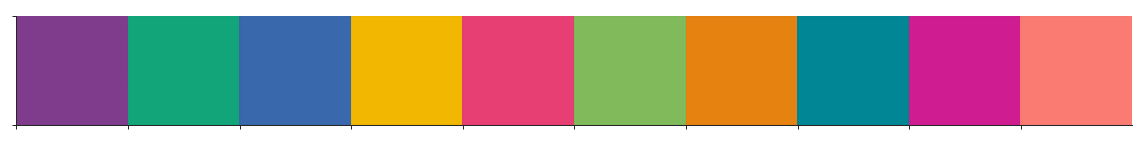

In [4]:
import palettable

cartocolors = dict(zip(
    ['Bold_purple', 
     'Bold_green', 
     'Bold_blue',
     'Bold_yellow',
     'Bold_pink',
     'Bold_lime_green',
     'Bold_orange',
     'Bold_petrol',
     'Bold_magenta',
     'Bold_rose'],
    palettable.cartocolors.qualitative.Bold_10.hex_colors
))
sns.palplot(cartocolors.values())
    

In [5]:
from snapanalysis.config import OUTPUT_DIRECTORY as MAIN_OUTPUT_DIRECTORY
OUTPUT_DIRECTORY = os.path.join(MAIN_OUTPUT_DIRECTORY, 'ptm-response')

if not os.path.isdir(OUTPUT_DIRECTORY):
    os.makedirs(OUTPUT_DIRECTORY)

In [6]:
from snapanalysis.models.ptm_response.main import OUTPUT_FILE as PTM_RESPONSE_FILE

from snapanalysis.models.ptm_response.main import PREDICTOR_ORDER
predictors = PREDICTOR_ORDER

limma_results = pd.read_hdf(PTM_RESPONSE_FILE, '/ptm_stats/joint_limma_stats')
predictors_from_limma = limma_results.reset_index()['predictor'].unique()
assert all(p in predictors_from_limma for p in predictors)
assert all(p in predictors for p in predictors_from_limma)

long_matrices = {}
informative_pds = {}


with pd.HDFStore(PTM_RESPONSE_FILE, 'r') as store: 
    enrichment_complexes = store['/ptm_stats/joint_camera_complexes']
    
    
    for predictor in predictors:
        long_matrices[predictor] = lm = store[f'/ptm_stats/{predictor}/long_matrix']
        informative_pds[predictor] = sorted(lm['Pull-Down ID'].unique())
            

In [7]:
limma_results.to_csv(os.path.join(OUTPUT_DIRECTORY, 'limma_results_dump.tsv'), sep='\t')

In [8]:


color_palette = {
    'Other': '#969696',
}

edge_color_palette = {
    'Other': 'none',
    'Other (significant)': '#525252',
    'Highlighted (other)': '#525252',
}


order = color_palette.keys()

In [9]:
matrix_wide = limma_results.unstack('predictor')

In [10]:
from adjustText import adjust_text
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import DBSCAN

In [11]:
members_of('MOZ/MORF')

['BRD1', 'BRPF1', 'BRPF3', 'ING5', 'KAT6A', 'MEAF6']

In [12]:
import colorsys
from matplotlib.colors import rgb2hex
# https://stackoverflow.com/a/49601444/171400
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    rgb = colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])
    
    return rgb2hex(rgb)
    

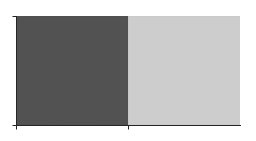

In [13]:
sns.palplot(['#525252', adjust_lightness('#525252', amount=2.5)])

In [14]:
from matplotlib.colors import Normalize

def rotate_by_angle(point, theta):
    # https://scipython.com/book/chapter-6-numpy/examples/creating-a-rotation-matrix-in-numpy/
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    
    rotp = R.dot(point)
    return rotp

def make_plot(x, y, 
              matrix_wide, 
              values='logFC', 
              highly_significant='significant_and_large_fc',
              significant='significant',
              outlier_fraction=0.02,
              angle_offset=0.2,
              highlights=None,
              palette=None,
              figsize=(2,2),
              dpi=DPI,
              cmap=None,
              cmap_lims=(-1.5, 1.5)
              ):
    
    markers = {
        'none': 'o',
        # This ends up being very visualy awkward, making the visualisation too dense to read
        # we sacrifice knowing which dimension was significant for better readability
        'x-only': 'o',
        'y-only': 'o',
#         'x-only': '>',
#         'y-only': '^',
        'both': 'o',
    }

    if palette is None:
        palette = {}
    
    if 'Other' not in palette:
        palette = palette.copy()
        palette['Other'] = '#bdbdbd'
        
    if highlights is None:
        highlights = {}
    
    df = matrix_wide[values][[x, y]]
    
    if cmap is not None:
        cmap_norm = Normalize(*cmap_lims)
    
    # The code below, dropping with how='all' 
    # generates lots proteins with x=0, which might be interesting in general
    # but not for what we're trying to show in the figure
    #df = df.dropna(axis=0, how='all').copy()
    #df = df.fillna(0)
    
    # We therefore only show proteins which have a measured response
    df = df.dropna(axis=0, how='any').copy()
    
    df_highly_significant = matrix_wide.loc[df.index, highly_significant][[x, y]].fillna(False)
    df_significant = matrix_wide.loc[df.index, significant][[x, y]].fillna(False)
    

    # Find outliers (we'll label those regardless of highlights) 
    model = EllipticEnvelope(contamination=outlier_fraction)
    model.fit(df[[x, y]])
    is_outlier = pd.Series(model.predict(df[[x, y]]) == -1, index=df.index, name='is_outlier')
    
    # And highlight proteins
    is_highlighted = pd.Series([ix in highlights for ix in df.index], name='is_highlighted', index=df.index)
    
    # However only the proteins highly significant in at least one experiment will be labeled.
    highlightable_points = df_highly_significant.any(axis=1)
    
#     to_label_mask = (is_outlier | is_highlighted) & highlightable_points
    to_label_mask = is_outlier & highlightable_points
    to_label_index = df.index[to_label_mask]
    
    # Now let's get significance_classes
    def _signif_class(row):
        if row.all():
            return 'both'
        elif row[x]:
            return 'x-only'
        elif row[y]:
            return 'y-only'
        else:
            return 'none'
        
    significance_class = df_significant.apply(_signif_class, axis=1)
    significance_class.name = 'significance_class'
    
    highlight_class = pd.Series('Other', index=df.index, name='highlight_class')
    for k, v in highlights.items():
        highlight_class.loc[k] = v
    
    plot_df = df.join(significance_class).join(is_highlighted).join(highlight_class)
    

    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = plt.gca()
    
    for (class_, highlighted_, signif_class_), subdf in plot_df.groupby([
        'highlight_class', 'is_highlighted', 'significance_class'
    ]):
        
        subindex = subdf.index
         
        alpha = 0.8
        
        if not highlighted_:
            rasterized = True
        else:
            rasterized = False
            
       
        marker = markers[signif_class_]
        
       
        
        if cmap is None:
            color = palette[class_]
            edgecolor = '#525252'
        else:
            diff = subdf[y] - subdf[x]
            color = cmap(cmap_norm(diff.values))
            edgecolor = palette[class_]
        
        # For insignificant datapoints, brighten the colour 2.5 times
        if signif_class_ == 'none':
            edgecolor = adjust_lightness(edgecolor, amount=2.5)
        
#         print(class_, edgecolor)
        
        
        if class_ == 'Other':
            zorder = 1
            markersize = 5
        else:
            zorder = 2
            markersize = 10
            
        ax.scatter(subdf[x], subdf[y], 
                    edgecolor=edgecolor,
                    linewidth=0.25,
                    marker=marker,
                    label='',
                    alpha=alpha,
                    zorder=zorder,
                    color=color,
                    s=markersize,
                    rasterized=rasterized)
        
    texts = []
    for label, row in df.loc[to_label_index].iterrows():
        class_ = highlight_class.loc[label]
        if class_ == 'Other':
            color = 'black'
        else:
            color = palette[class_]
            
        text = ax.text(row[x], row[y], label, 
                       color=color, fontsize=5)
        texts.append(text)
    
    axis_line_color = '#969696'
    adjust_text(texts, df[x].values, df[y].values, 
                force_points=(0.5, 0.5), 
                force_text=(0.25, 0.25),
                arrowprops=dict(arrowstyle='-', color=axis_line_color, linewidth=0.5)
               )

    ax.set_xlabel(f'Estimated effect of {x}\n(change in log2 H/L ratio)')
    ax.set_ylabel(f'Estimated effect of {y}\n(change in log2 H/L ratio)')
    ax.set_title(f'{x} v. {y}')

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    min_ = np.min([xlim, ylim])
    max_ = np.max([xlim, ylim])
    
    absmax = np.max(np.abs([min_, max_]))
    line_drawing_limit = absmax * 2

    
    ax.plot([-line_drawing_limit, line_drawing_limit], [-line_drawing_limit, line_drawing_limit], 
            linestyle=':',
            linewidth=1.0,
            zorder=0, 
            color=axis_line_color,
           )
    

    ax.axvline(0, color=axis_line_color, zorder=0, linestyle='-', linewidth=0.5)
    ax.axhline(0, color=axis_line_color, zorder=0, linestyle='-', linewidth=0.5)
    
    shading_dict = dict(color='#969696', alpha=.1, zorder=0)
    # Diagonal shading
    vector = np.asarray([1,1]) * line_drawing_limit

    ## Diagonal Above (positive/negative)
    for sign_symmetry in [-1.0, 1.0]:
        for sign_angle in [-1.0, 1.0]:
            rotated_vector = rotate_by_angle(sign_symmetry * vector, sign_symmetry * sign_angle * angle_offset)  

            ax.fill_between(
                [0, rotated_vector[0]],
                [0, rotated_vector[0]],
                [0, rotated_vector[1]],
                **shading_dict,
            )
            
#     # Horizontal shading
#     vector = np.asarray([1,0]) * line_drawing_limit


#     for sign_symmetry in [-1.0, 1.0]:
#         for sign_angle in [-1.0, 1.0]:
#             rotated_vector = rotate_by_angle(sign_symmetry * vector, sign_symmetry * sign_angle * angle_offset)  

#             ax.fill_between(
#                 [0, rotated_vector[0]],
#                 [0, 0],
#                 [0, rotated_vector[1]],
#                 **shading_dict
#             )
    
#     # Vertical shading
#     vector = np.asarray([0,1]) * line_drawing_limit

#     for sign_symmetry in [-1.0, 1.0]:
#         for sign_angle in [-1.0, 1.0]:
#             rotated_vector = rotate_by_angle(sign_symmetry * vector, sign_symmetry * sign_angle * angle_offset)  

#             ax.fill_between(
#                 [rotated_vector[0], 0],
#                 [rotated_vector[1], rotated_vector[1]],
#                 [rotated_vector[1], 0],
#                 **shading_dict
#             )

    
    ax.set_xlim(min_, max_)
    ax.set_ylim(min_, max_)
    
    sns.despine(ax=ax, offset=5)
    ax.set_aspect('equal')
    ax.grid(False)
    
    return df
    

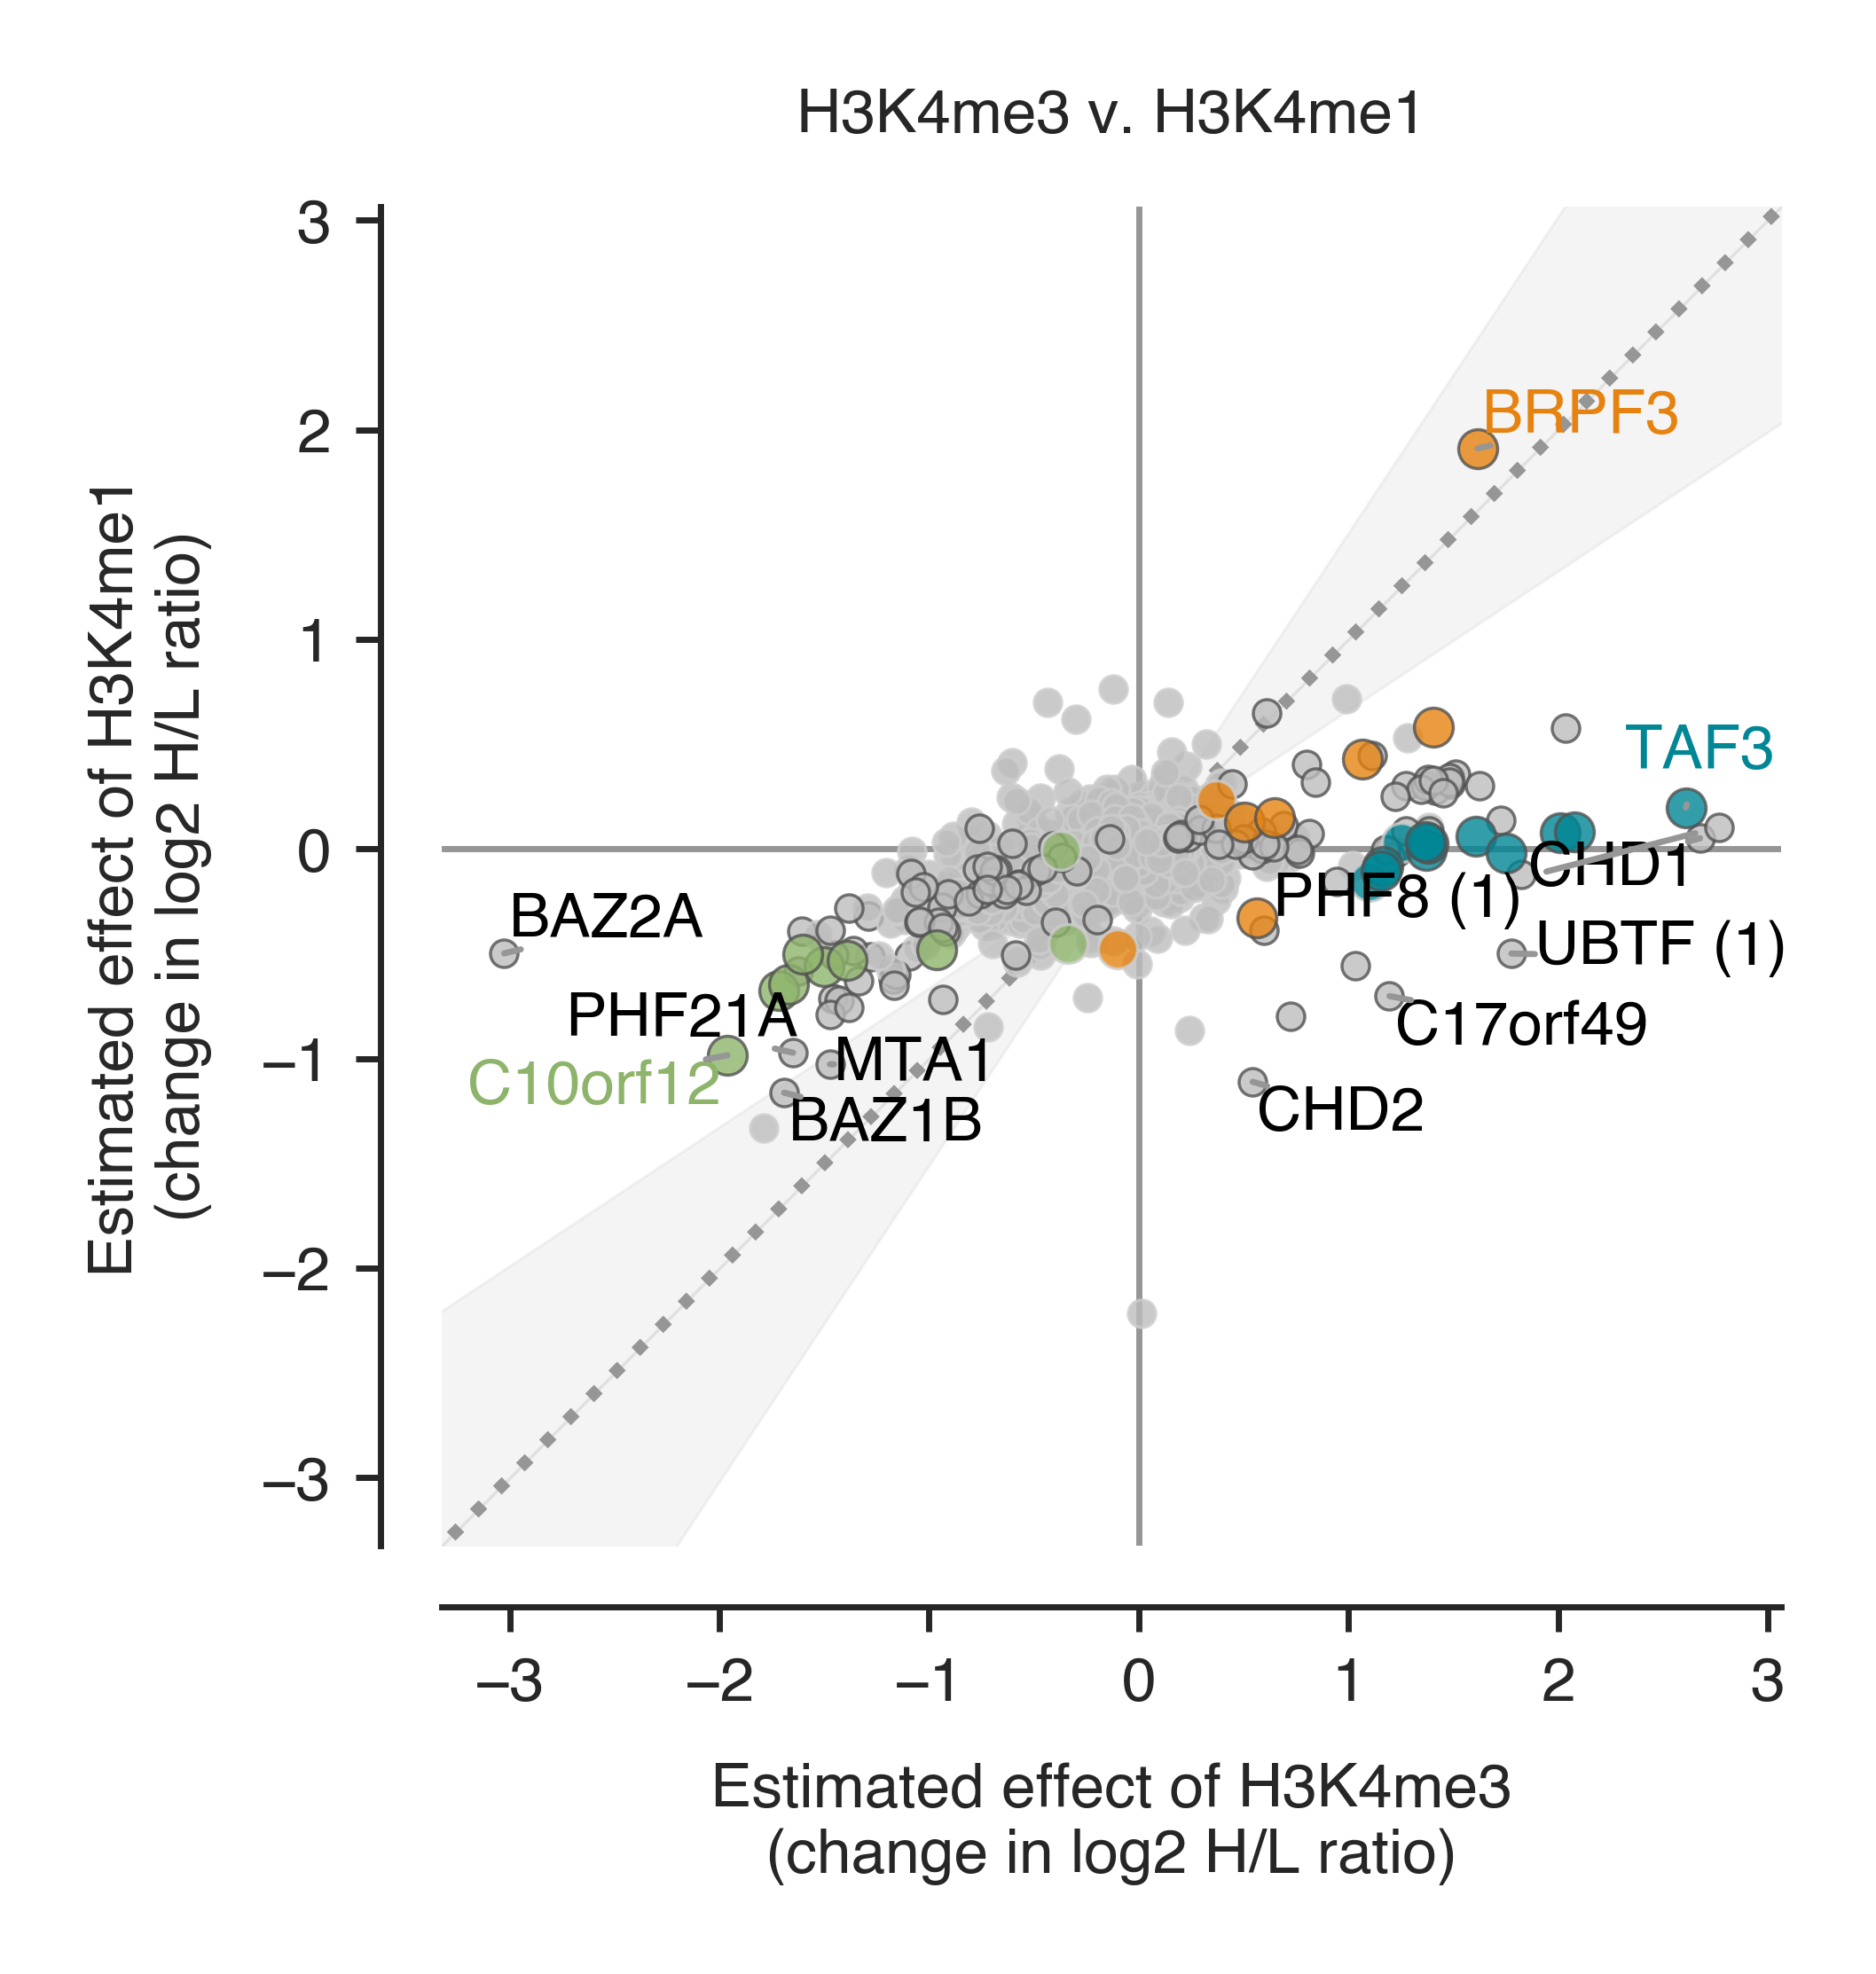

In [15]:
# Colors borrowed from equivalent volcano plot
highlights = {}

skip = {
    'HDAC1', 'RBBP4', 'RBBP7', 'HDAC2', # Common among many complexes.
}

for (complex_, complex_label) in [
    ('TFIID', 'TFIID'),
    (['HBO1', 'MOZ/MORF'], 'MOZ/MORF/HBO1'),
    ('PRC2.1', 'PRC2.1'),
]:
    for protein in members_of(complex_):
        if protein in skip:
            continue
        
        if protein in highlights:
            raise Exception(f'Duplicate mapping for {protein}')
        
        highlights[protein] = complex_label

palette_highlights = {}
palette_highlights['TFIID'] = cartocolors['Bold_petrol']
palette_highlights['MOZ/MORF/HBO1'] = cartocolors['Bold_orange']
palette_highlights['PRC2.1'] = '#8EB46B'

_x = 'H3K4me3'
_y = 'H3K4me1'

__ = make_plot(_x, _y, matrix_wide, outlier_fraction=0.01, highlights=highlights, palette=palette_highlights)
plt.savefig(os.path.join(OUTPUT_DIRECTORY, f'pairwise_scatterplot_{_x}v{_y}.pdf'), dpi=500, bbox_inches='tight')

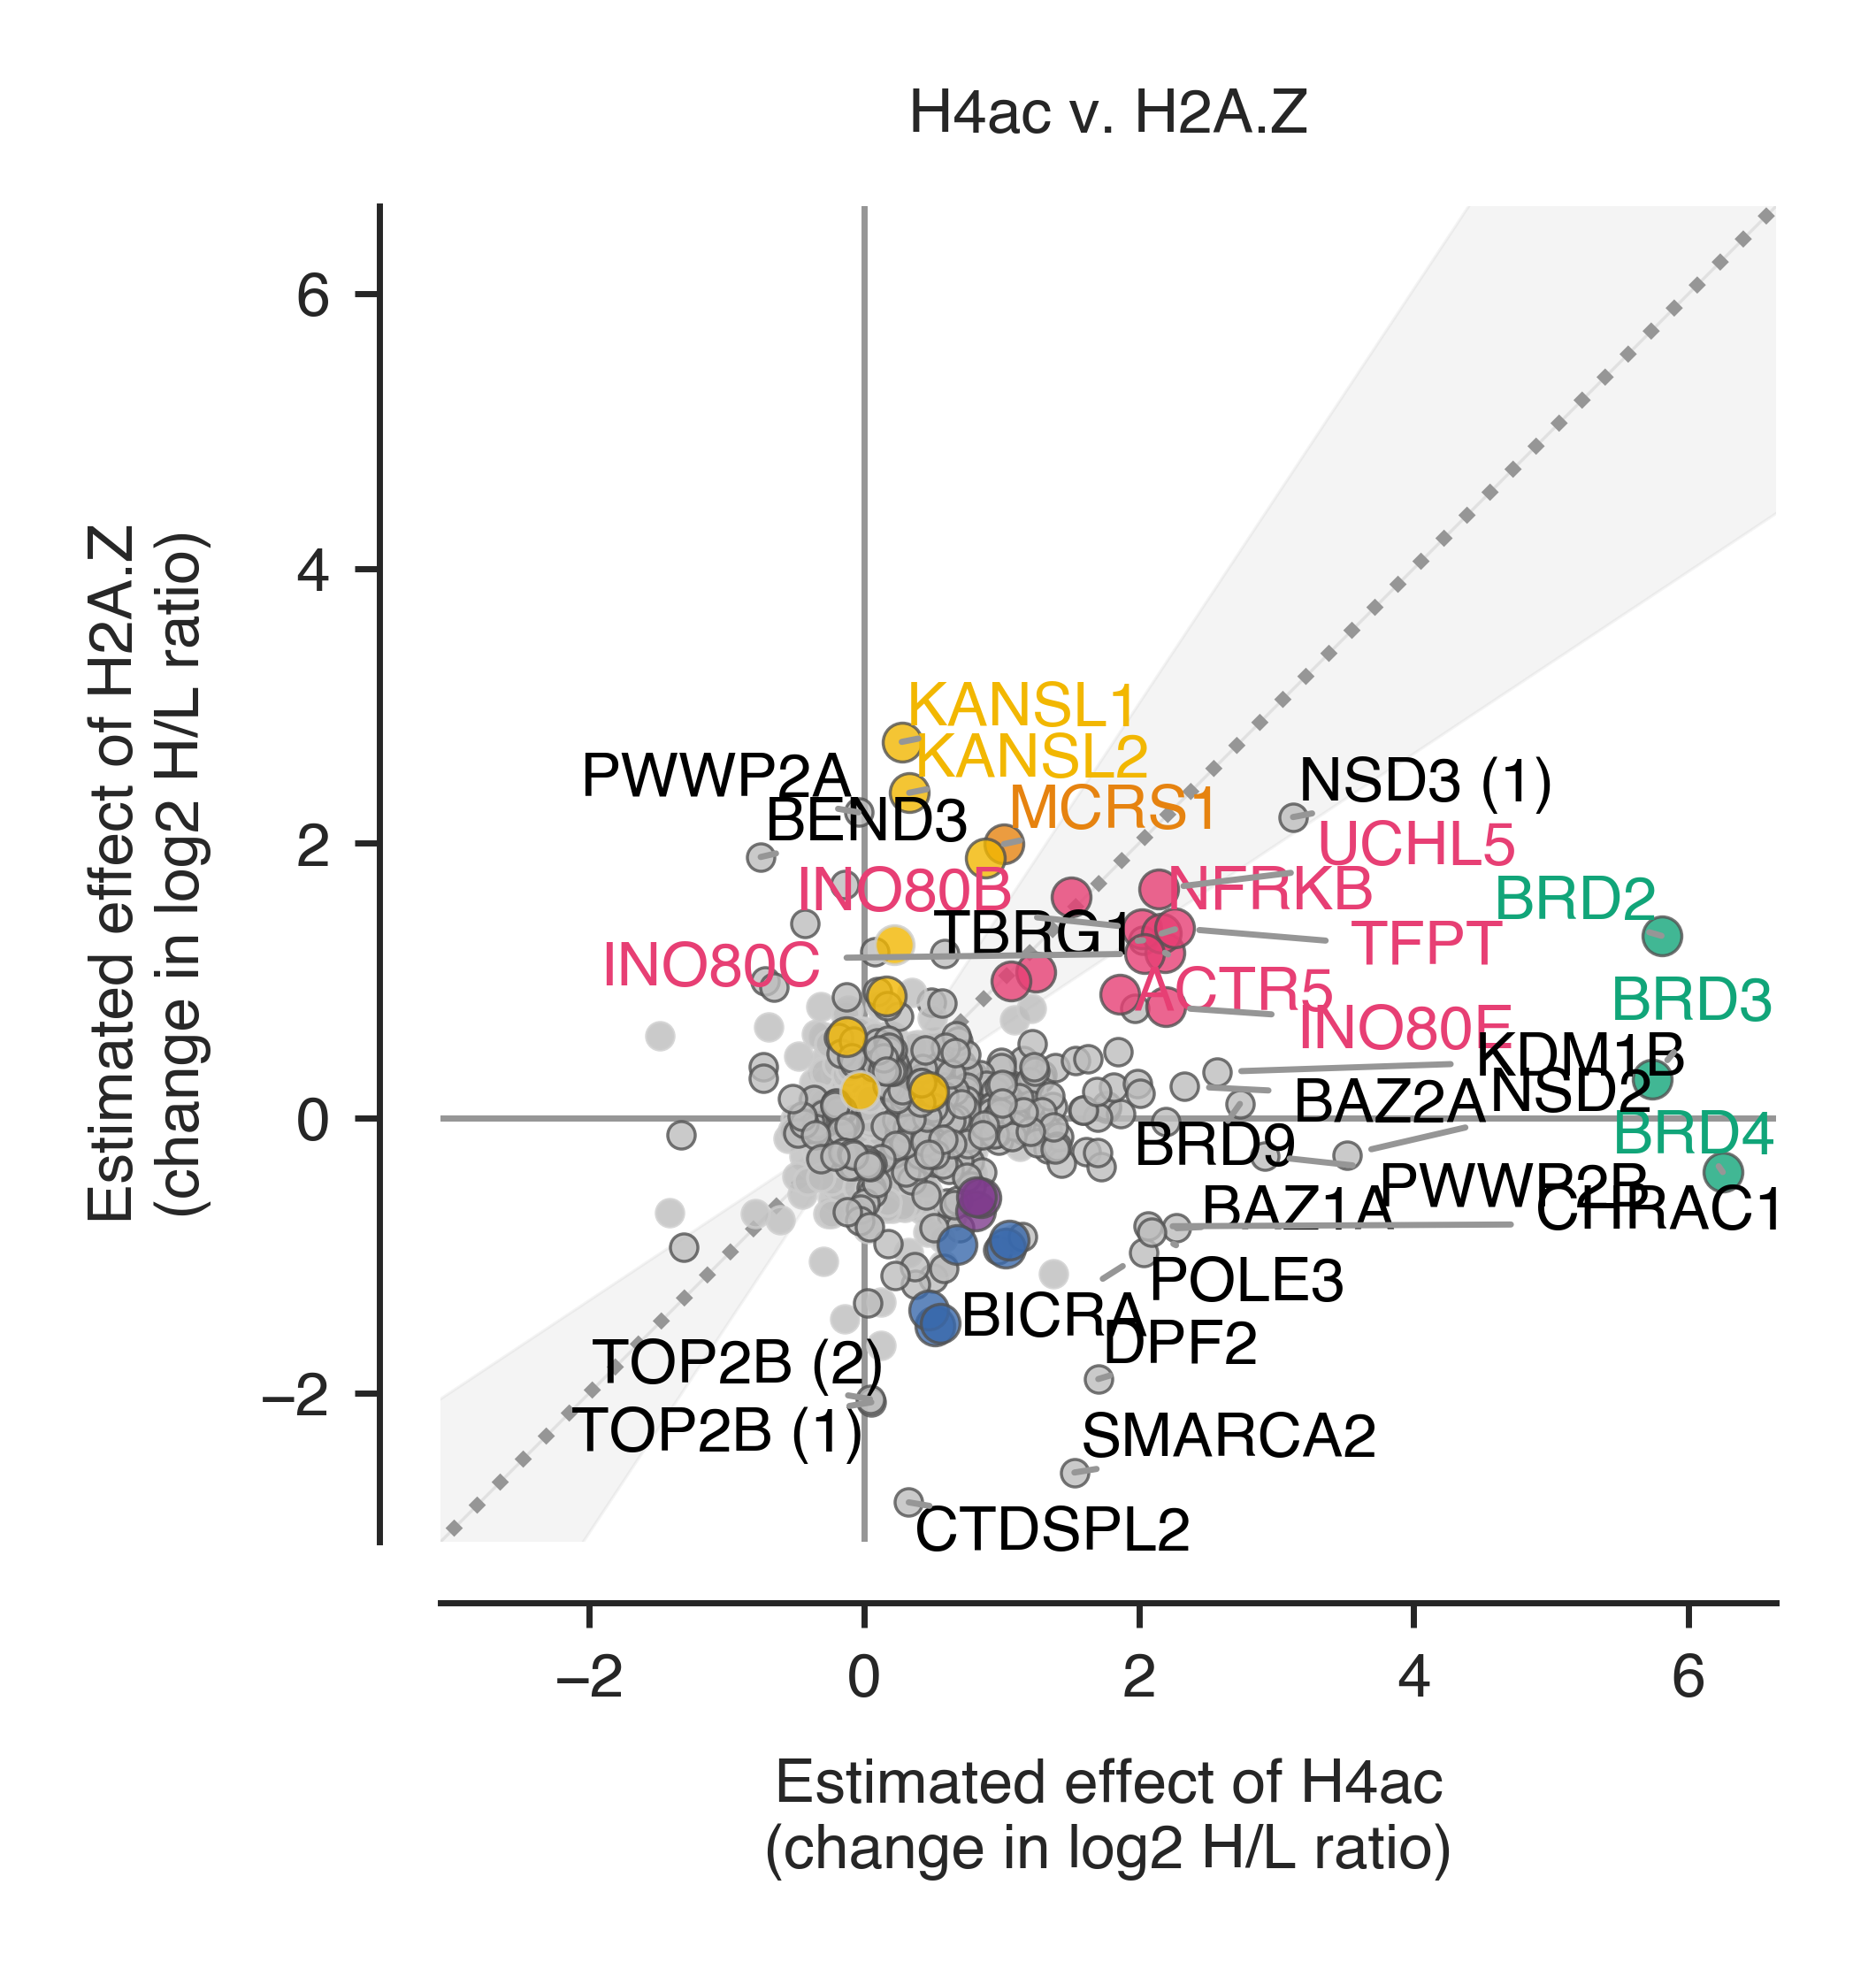

In [16]:
highlights = {}

skip = {
    'MCRS1', # INO80/NSL
    
    # INO80/SRCAP
    'RUVBL1', 
    'RUVBL2',
    'ACTL6A',
}


for (complex_, complex_label) in [
    ('NSL', 'NSL'),
    ('SRCAP', 'SRCAP'),
    ('INO80', 'INO80'),
]:
    for protein in members_of(complex_):
        if protein in skip:
            continue
        
        if protein in highlights:
            raise Exception(f'Duplicate mapping for {protein}')
        
        highlights[protein] = complex_label

# Readd skipped labels
for protein in ['MCRS1']:
    if protein in highlights:
        raise Exception(f'Duplicate mapping for {protein}')
        
    highlights[protein] = 'INO80/NSL'
    
for protein in ['RUVBL1', 'RUVBL2', 'ACTL6A']:
    if protein in highlights:
        raise Exception(f'Duplicate mapping for {protein}')
        
    highlights[protein] = 'INO80/SRCAP'
    
    
for protein in ['BRD2', 'BRD3', 'BRD4']:
    if protein in highlights:
        raise Exception(f'Duplicate mapping for {protein}')
        
    highlights[protein] = 'BET'
    
    
# for protein in ['TOP2A', 'TOP2B (1)', 'TOP2B (2)']:
#     if protein in highlights:
#         raise Exception(f'Duplicate mapping for {protein}')
        
#     highlights[protein] = 'TOP2A/B'
    
    
# sns.palplot([cartocolors['Bold_blue'], cartocolors['Bold_purple'], 'black'])
#sns.palplot([cartocolors['Bold_yellow'], cartocolors['Bold_pink'], '#BE5846'])


palette = {
    'NSL': cartocolors['Bold_yellow'],
    'SRCAP': cartocolors['Bold_blue'],
    'INO80': cartocolors['Bold_pink'],
    'INO80/NSL':cartocolors['Bold_orange'],
    'INO80/SRCAP': cartocolors['Bold_purple'],
    'BET': cartocolors['Bold_green'],
   # 'TOP2A/B': '#000000',
}

_x = 'H4ac'
_y = 'H2A.Z'

__ = make_plot(_x, _y, matrix_wide, outlier_fraction=0.02, highlights=highlights, palette=palette)
plt.savefig(os.path.join(OUTPUT_DIRECTORY, f'pairwise_scatterplot_{_x}v{_y}.pdf'), dpi=500, bbox_inches='tight')

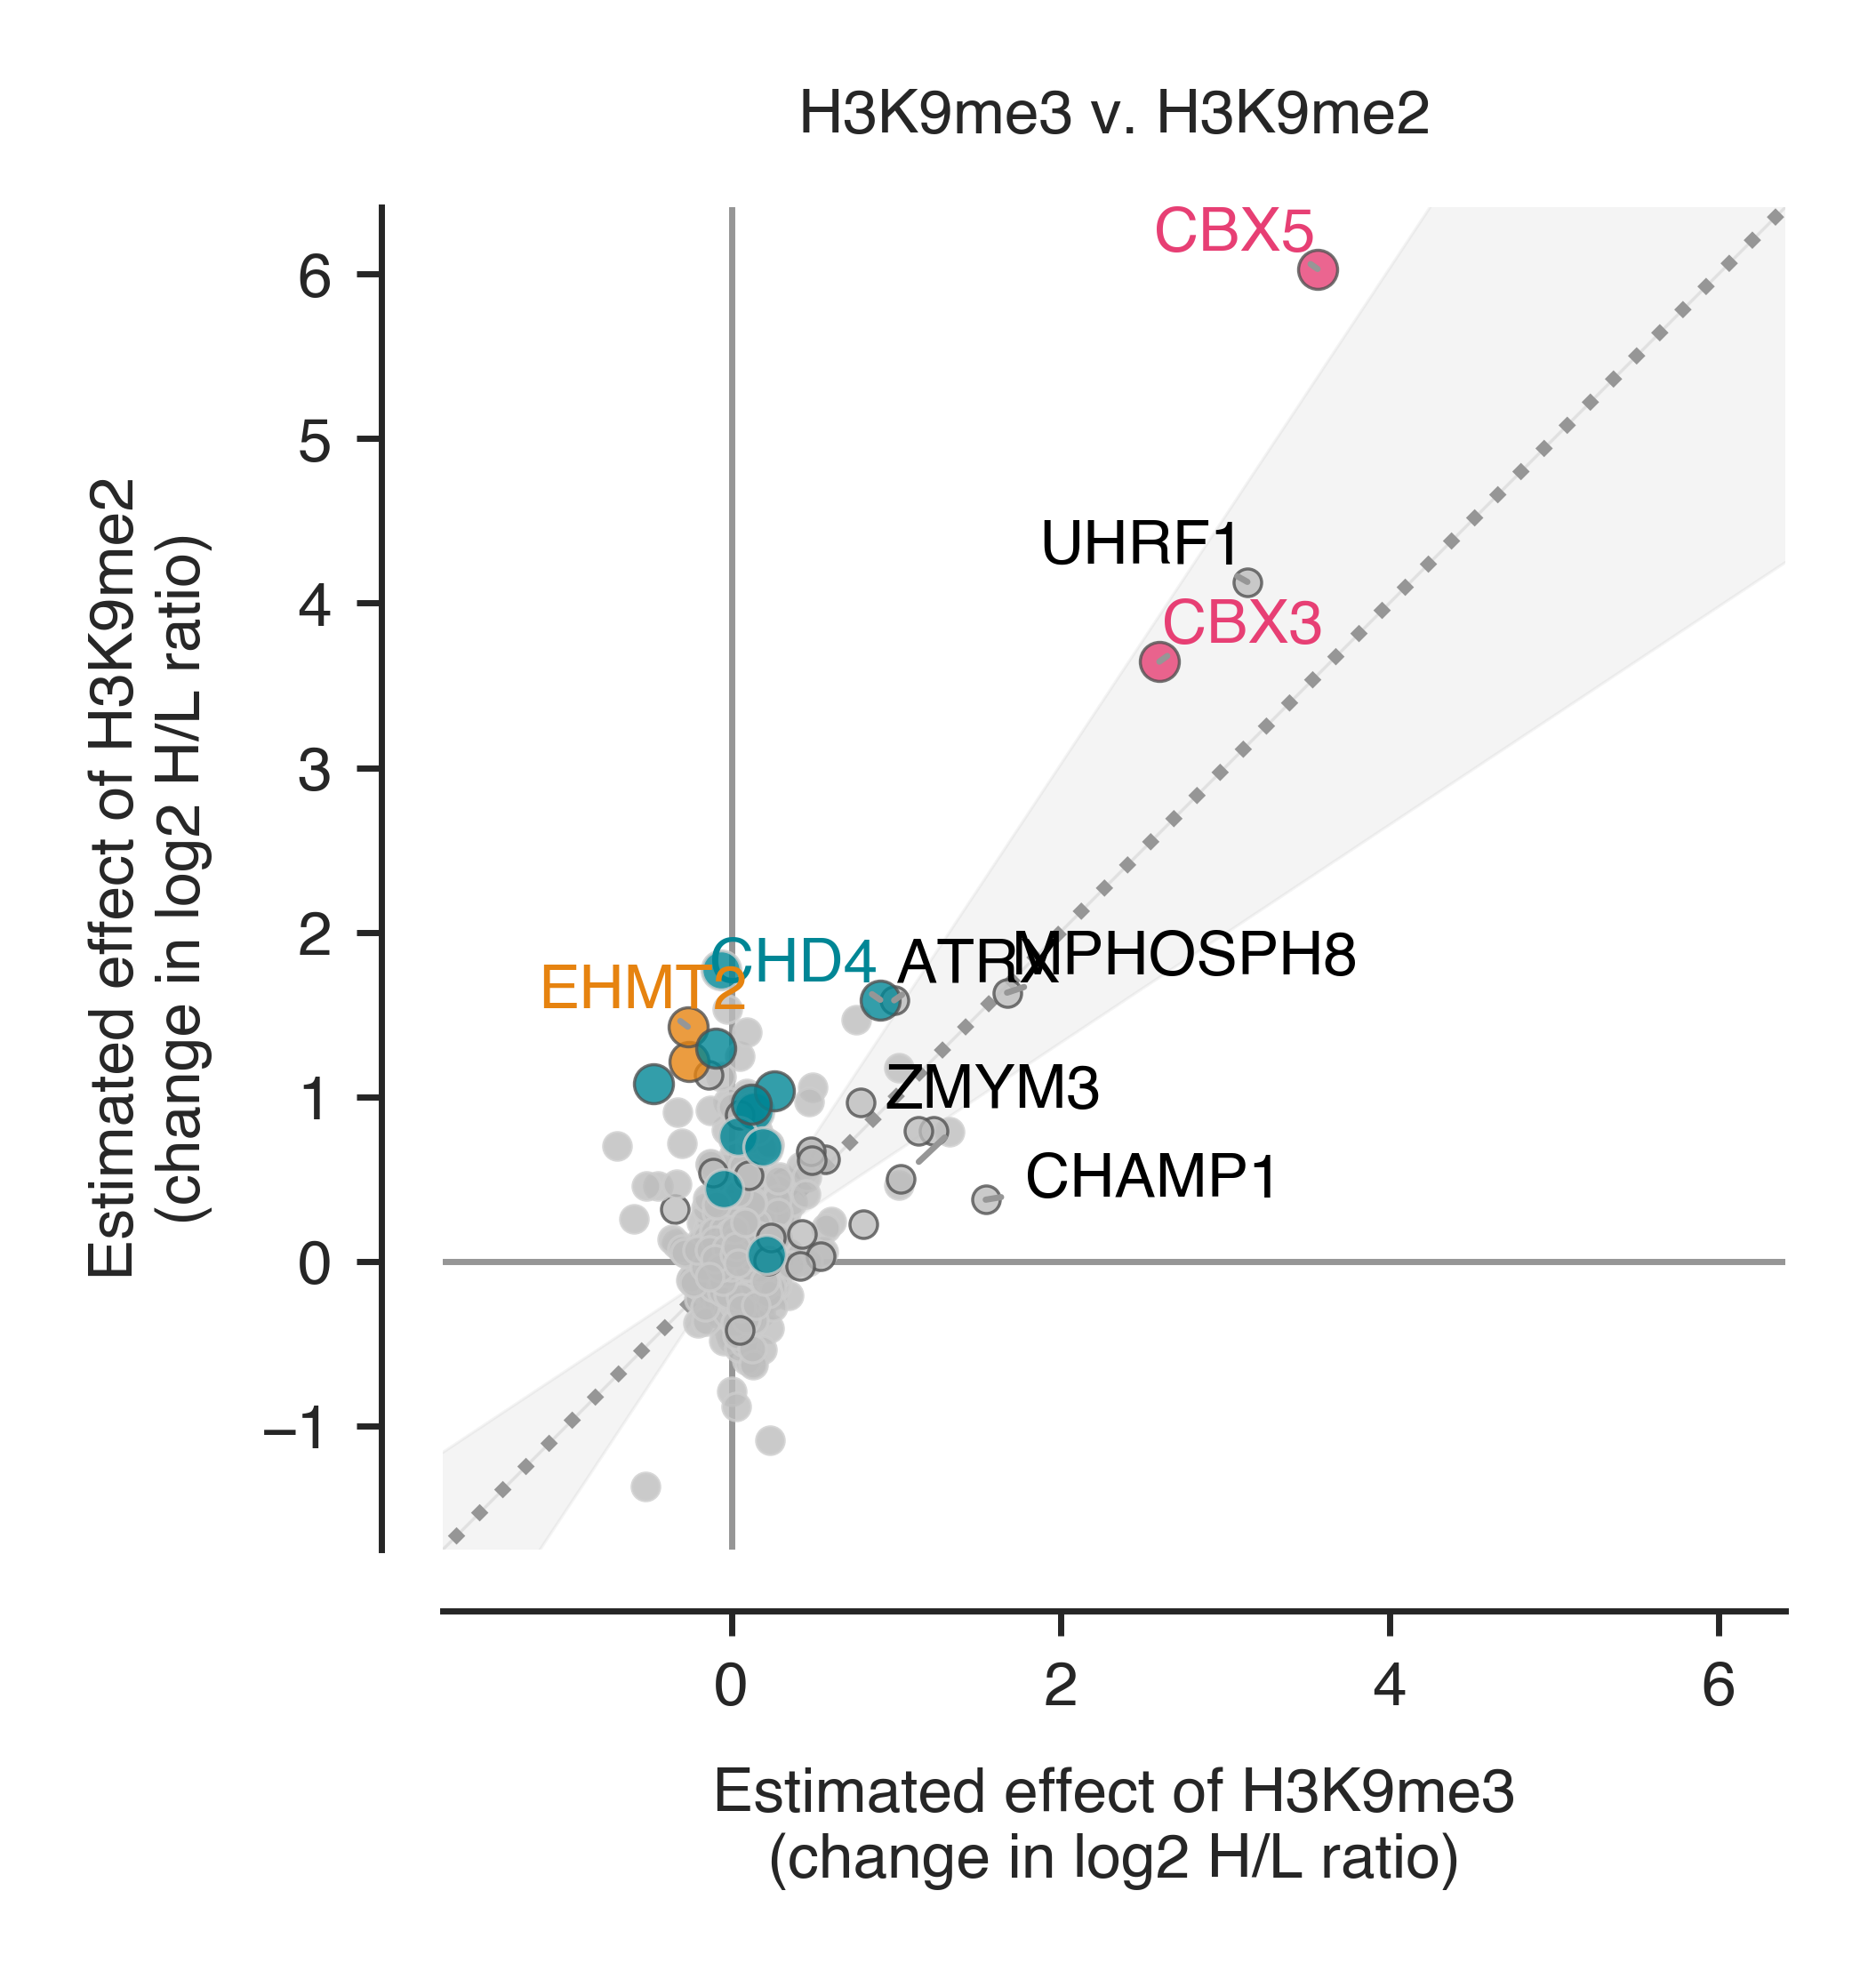

In [17]:
highlights = {}

skip = {
}

for (complex_, complex_label) in [
    ('G9a/GLP', 'G9a/GLP'),
    ('NuRD', 'NuRD')
]:
    for protein in members_of(complex_):
        if protein in skip:
            continue
        
        if protein in highlights:
            raise Exception(f'Duplicate mapping for {protein}')
        
        highlights[protein] = complex_label


highlights['CBX3'] = 'HP1'
highlights['CBX5'] = 'HP1'


palette = {}
palette['HP1'] = cartocolors['Bold_pink']
palette['G9a/GLP'] = cartocolors['Bold_orange']
palette['NuRD'] = cartocolors['Bold_petrol']

_x = 'H3K9me3'
_y = 'H3K9me2'

__ = make_plot(_x, _y, matrix_wide, outlier_fraction=0.02, highlights=highlights, palette=palette)
plt.savefig(os.path.join(OUTPUT_DIRECTORY, f'pairwise_scatterplot_{_x}v{_y}.pdf'), dpi=500, bbox_inches='tight')

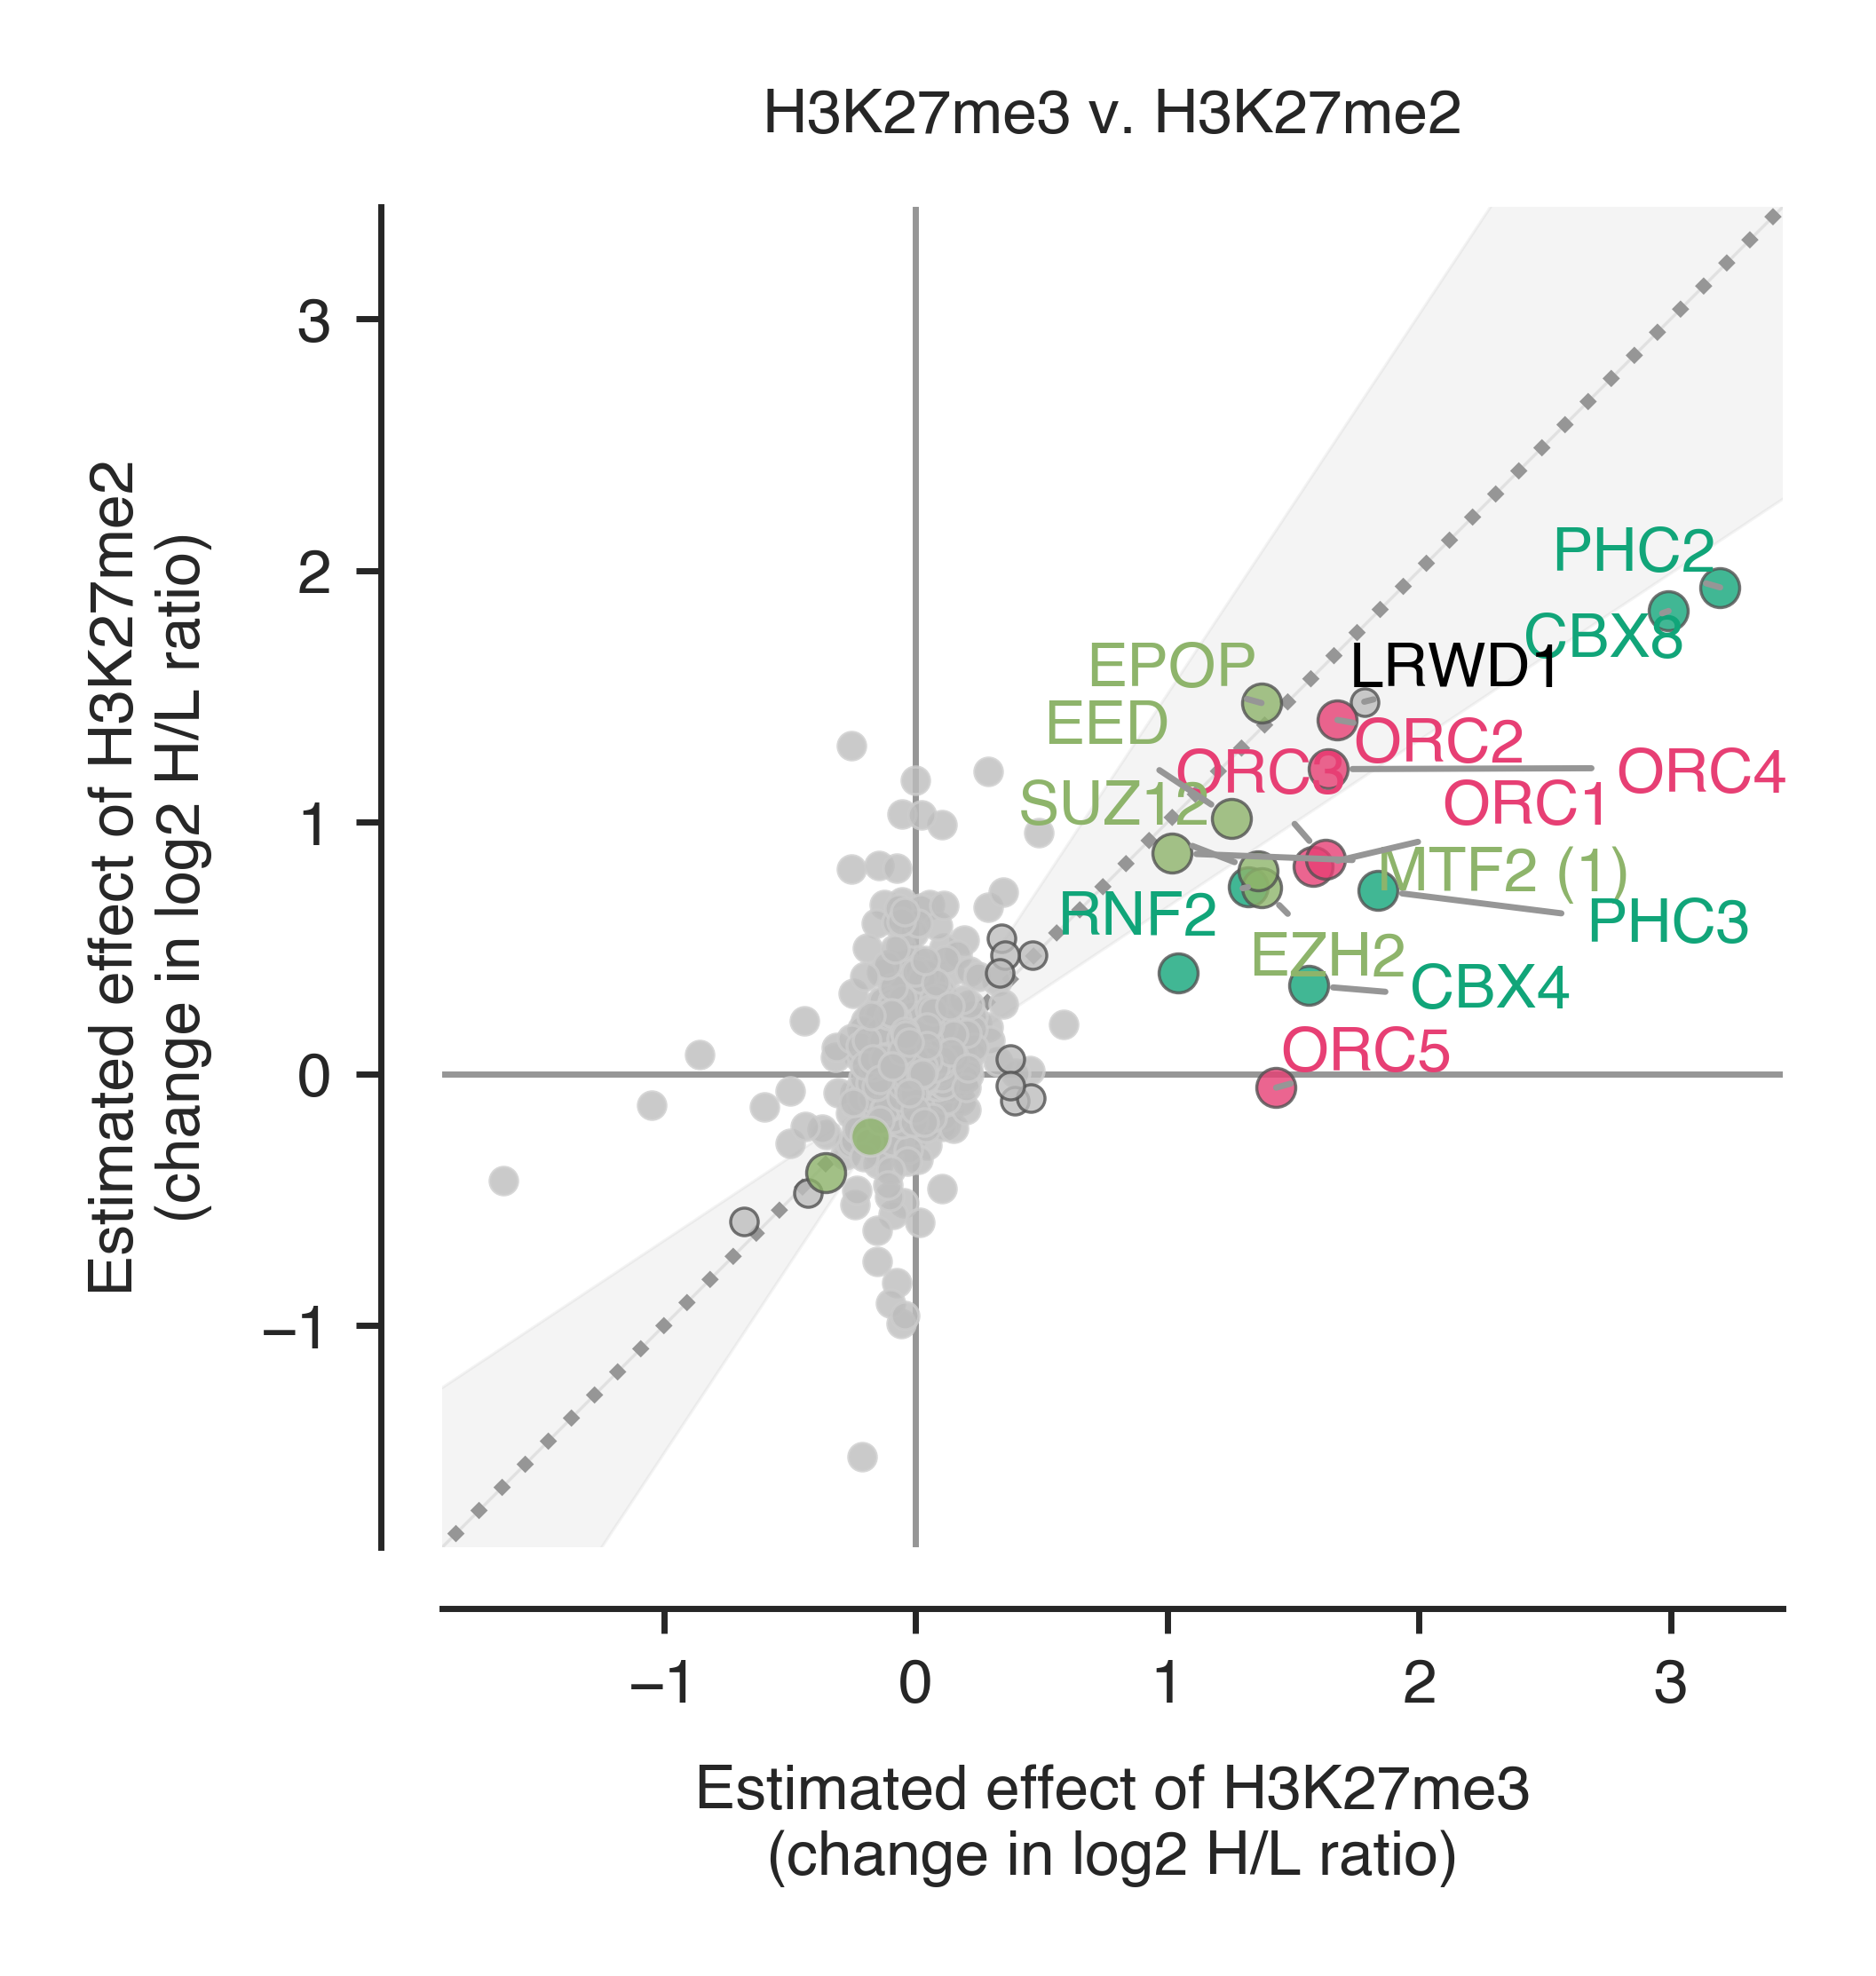

In [18]:
highlights = {}

skip = {
    'HDAC1', 'RBBP4', 'RBBP7', 'HDAC2', # Common among many complexes.
}

for (complex_, complex_label) in [
    ('ORC', 'ORC'),
    ('PRC2.1', 'PRC2.1'),
    ('PRC1', 'PRC1'),
]:
    for protein in members_of(complex_):
        if protein in skip:
            continue
        
        if protein in highlights:
            raise Exception(f'Duplicate mapping for {protein}')
        
        highlights[protein] = complex_label



palette = {}
palette['PRC2.1'] = '#8EB46B'
palette['PRC1'] = cartocolors['Bold_green']
palette['ORC'] = cartocolors['Bold_pink']

_x = 'H3K27me3'
_y = 'H3K27me2'

__ = make_plot(_x, _y, matrix_wide, outlier_fraction=0.02, highlights=highlights, palette=palette)
plt.savefig(os.path.join(OUTPUT_DIRECTORY, f'pairwise_scatterplot_{_x}v{_y}.pdf'), dpi=500, bbox_inches='tight')

In [ ]:

highlights = {}

skip = {
}

for (complex_, complex_label) in [
    ('ORC', 'ORC'),
    ('ATAC', 'ATAC'),
    ('SLF1/2-RAD18', 'SLF1/2'),
    ('BRCA1-A', 'BRCA1-A'),
]:
    for protein in members_of(complex_):
        if protein in skip:
            continue
        
        if protein in highlights:
            raise Exception(f'Duplicate mapping for {protein}')
        
        highlights[protein] = complex_label



palette_highlights = {}
palette_highlights['ATAC'] = cartocolors['Bold_purple']
palette_highlights['SLF1/2'] = cartocolors['Bold_orange']
palette_highlights['BRCA1-A'] = cartocolors['Bold_yellow']
palette_highlights['ORC'] = cartocolors['Bold_pink']

_x = 'H4K20me3'
_y = 'H4K20me2'

__ = make_plot(_x, _y, matrix_wide, outlier_fraction=0.02, highlights=highlights, palette=palette_highlights)
plt.savefig(os.path.join(OUTPUT_DIRECTORY, f'pairwise_scatterplot_{_x}v{_y}.pdf'), dpi=500, bbox_inches='tight')

In [ ]:
highlights = {}

skip = {
}

for (complex_, complex_label) in [
    (['BAF', 'PBAF', "EBAFA/B"], '[EP]BAF'),
    (['CHRAC'], 'CHRAC'),
    (['GBAF'], 'GBAF-specific'),
]:
    for protein in members_of(complex_):
        if protein in skip:
            continue
        
        if protein in highlights:
            
            # Exception for this case as we only want to highlight GBAF-specific proteins
            if complex_label == 'GBAF-specific' and highlights[protein] == '[EP]BAF':
                continue
            
            raise Exception(f'Duplicate mapping for {protein}')
        
        highlights[protein] = complex_label
        
palette_highlights = {}
palette_highlights['[EP]BAF'] = '#C1607E' # Red (H3ac preference)
palette_highlights['GBAF-specific'] = cartocolors['Bold_orange']
palette_highlights['CHRAC'] = '#479A8E'
_x = 'H3ac'
_y = 'H4ac'

__ = make_plot(_x, _y, matrix_wide, 
               cmap=palettable.cartocolors.diverging.Temps_7_r.mpl_colormap,
               outlier_fraction=0.02, highlights=highlights, palette=palette_highlights)
plt.savefig(os.path.join(OUTPUT_DIRECTORY, f'pairwise_scatterplot_{_x}v{_y}.pdf'), dpi=500, bbox_inches='tight')

In [ ]:
highlights = {}

skip = {
}

for (complex_, complex_label) in [
    (['BAF', 'PBAF', "EBAFA/B", "GBAF"], '[EGP]BAF')
]:
    for protein in members_of(complex_):
        if protein in skip:
            continue
        
        if protein in highlights:
            raise Exception(f'Duplicate mapping for {protein}')
        
        highlights[protein] = complex_label


highlights['BRD2'] = 'BET'
highlights['BRD3'] = 'BET'
highlights['BRD4'] = 'BET'
        
palette_highlights = {}
palette_highlights['[EGP]BAF'] = cartocolors['Bold_petrol']
palette_highlights['BET'] = cartocolors['Bold_green']

_x = 'H3ac'
_y = 'H3K9acK14ac'

__ = make_plot(_x, _y, matrix_wide, outlier_fraction=0.01, highlights=highlights, palette=palette_highlights)
plt.savefig(os.path.join(OUTPUT_DIRECTORY, f'pairwise_scatterplot_{_x}v{_y}.pdf'), dpi=500, bbox_inches='tight')

In [ ]:
highlights = {}

skip = {
    'HDAC1', 'RBBP4', 'RBBP7', 'HDAC2', # Common among many complexes.
}

for (complex_, complex_label) in [
    ('TFIID', 'TFIID'),
    (['HBO1', 'MOZ/MORF'], 'MOZ/MORF/HBO1'),
    ('PRC2.1', 'PRC2.1'),
    ('SRCAP', 'SRCAP'),
]:
    for protein in members_of(complex_):
        if protein in skip:
            continue
        
        if protein in highlights:
            raise Exception(f'Duplicate mapping for {protein}')
        
        highlights[protein] = complex_label

palette_highlights = {}
palette_highlights['TFIID'] = cartocolors['Bold_petrol']
palette_highlights['MOZ/MORF/HBO1'] = cartocolors['Bold_orange']
palette_highlights['PRC2.1'] = '#8EB46B'
palette_highlights['SRCAP'] = cartocolors['Bold_magenta']


_x = 'H3ac'
_y = 'H3K27ac'

__ = make_plot(_x, _y, matrix_wide, outlier_fraction=0.01, highlights=highlights, palette=palette_highlights)
plt.savefig(os.path.join(OUTPUT_DIRECTORY, f'pairwise_scatterplot_{_x}v{_y}.pdf'), dpi=500, bbox_inches='tight')

In [ ]:
highlights = {}

skip = {
    'HDAC1', 'RBBP4', 'RBBP7', 'HDAC2', # Common among many complexes.
}

for (complex_, complex_label) in [
    ('TFIID', 'TFIID'),
    (['HBO1', 'MOZ/MORF'], 'MOZ/MORF/HBO1'),
    ('PRC2.1', 'PRC2.1'),
    ('SRCAP', 'SRCAP'),
]:
    for protein in members_of(complex_):
        if protein in skip:
            continue
        
        if protein in highlights:
            raise Exception(f'Duplicate mapping for {protein}')
        
        highlights[protein] = complex_label

palette_highlights = {}
palette_highlights['TFIID'] = cartocolors['Bold_petrol']
palette_highlights['MOZ/MORF/HBO1'] = cartocolors['Bold_orange']
palette_highlights['PRC2.1'] = '#8EB46B'
palette_highlights['SRCAP'] = cartocolors['Bold_magenta']


_x = 'H3K4me1'
_y = 'H3K27ac'

__ = make_plot(_x, _y, matrix_wide, outlier_fraction=0.01, highlights=highlights, palette=palette_highlights)
plt.savefig(os.path.join(OUTPUT_DIRECTORY, f'pairwise_scatterplot_{_x}v{_y}.pdf'), dpi=500, bbox_inches='tight')

In [ ]:
highlights = {}

skip = {
    'HDAC1', 'RBBP4', 'RBBP7', 'HDAC2', # Common among many complexes.
}

for (complex_, complex_label) in [
    ('TFIID', 'TFIID'),
    (['HBO1', 'MOZ/MORF'], 'MOZ/MORF/HBO1'),
    ('PRC2.1', 'PRC2.1'),
    ('SRCAP', 'SRCAP'),
]:
    for protein in members_of(complex_):
        if protein in skip:
            continue
        
        if protein in highlights:
            raise Exception(f'Duplicate mapping for {protein}')
        
        highlights[protein] = complex_label

palette_highlights = {}
palette_highlights['TFIID'] = cartocolors['Bold_petrol']
palette_highlights['MOZ/MORF/HBO1'] = cartocolors['Bold_orange']
palette_highlights['PRC2.1'] = '#8EB46B'
palette_highlights['SRCAP'] = cartocolors['Bold_magenta']


_x = 'H3K4me3'
_y = 'H3K27ac'

__ = make_plot(_x, _y, matrix_wide, outlier_fraction=0.01, highlights=highlights, palette=palette_highlights)
plt.savefig(os.path.join(OUTPUT_DIRECTORY, f'pairwise_scatterplot_{_x}v{_y}.pdf'), dpi=500, bbox_inches='tight')